In [272]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Import all required libraries and packages

In [273]:
import os 
import sys 
import json
import logging
import numpy as np
import pandas as pd
from dotenv import load_dotenv

load_dotenv()

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

Define evnvironment variables and global constants

In [274]:
sys.path.append('/Users/nikolaynechay/Deloitte/Scanned-Documents-Processing')

In [275]:
RAW_DATA_DIR = os.getenv('RAW_DATA_DIR')
DATA_DIR = os.getenv('DATA_DIR')
TRAIN_DATA_DIR = os.getenv('TRAIN_DATA_DIR')
TEST_DATA_DIR = os.getenv('TEST_DATA_DIR')

Import all required modules

In [276]:
from src.core.providers.data_provider import KaggleDataProvider
from src.core.helpers.visualize_one_sample import visualize_one_sample
from src.core.helpers.helper_functions import get_data_paths, check_data_on_completeness, check_data_types
from src.core.helpers.helper_functions_for_texts import language_detection, output_all_classes_of_textual_data, main_statistics_for_textual_data
from src.core.helpers.helper_functions_for_images import number_of_channels, calculate_main_statistic_for_images
from src.core.helpers.character_segmentator import connected_component_analysis

# 🧾 Optical Character Segmentation for Scanned Documents

### 📌 Problem Definition

The goal of this notebook is to develop a robust solution for Optical Character Segmentation and Character Classification on noisy, scanned document images.

The pipeline includes:

🔹 Segmentation of words into individual characters
	
🔹 Classification of each segmented character

This task is fundamental for downstream processes like document digitization, information extraction, and intelligent OCR workflows.


### 📁 Data Format

The dataset is split into training and testing subsets. Each sample includes:

🖼️ Image

•	Format: .png

•	Color space: Grayscale (1 channel)

•	Structure: 2D array, pixel intensity in the range [0–255]

📝 Annotation (JSON format)

Each annotation file includes:

•	bounding_boxes: Coordinates of word-level bounding boxes

•	transcription: Ground-truth text for each word
	
•	label: One of the following categories: header, question, answer, other

🔠 All text is in English


### 📊 Evaluation Metrics

Model performance will be evaluated using the following metrics:

🔹 Character Segmentation Metrics:
	-------

🔹 Character Classification Metrics:

•	Accuracy – Proportion of correctly classified characters
	
•	F1-Score

•	Confusion Matrix

🔹 Final Quality Metrics:

•	Word Error Rate (WER) – Measures transcription accuracy at the word level

•	Sequence Error Rate (SER) – Measures errors per word/line sequence


# Data Collection

Display a random sample of data to check the correctness of the annotation.

In [277]:
# visualize_one_sample(
#     sample_name='00040534',
#     data_dir=DATA_DIR,
#     data_type='raw',
#     flag='training_data'
# )

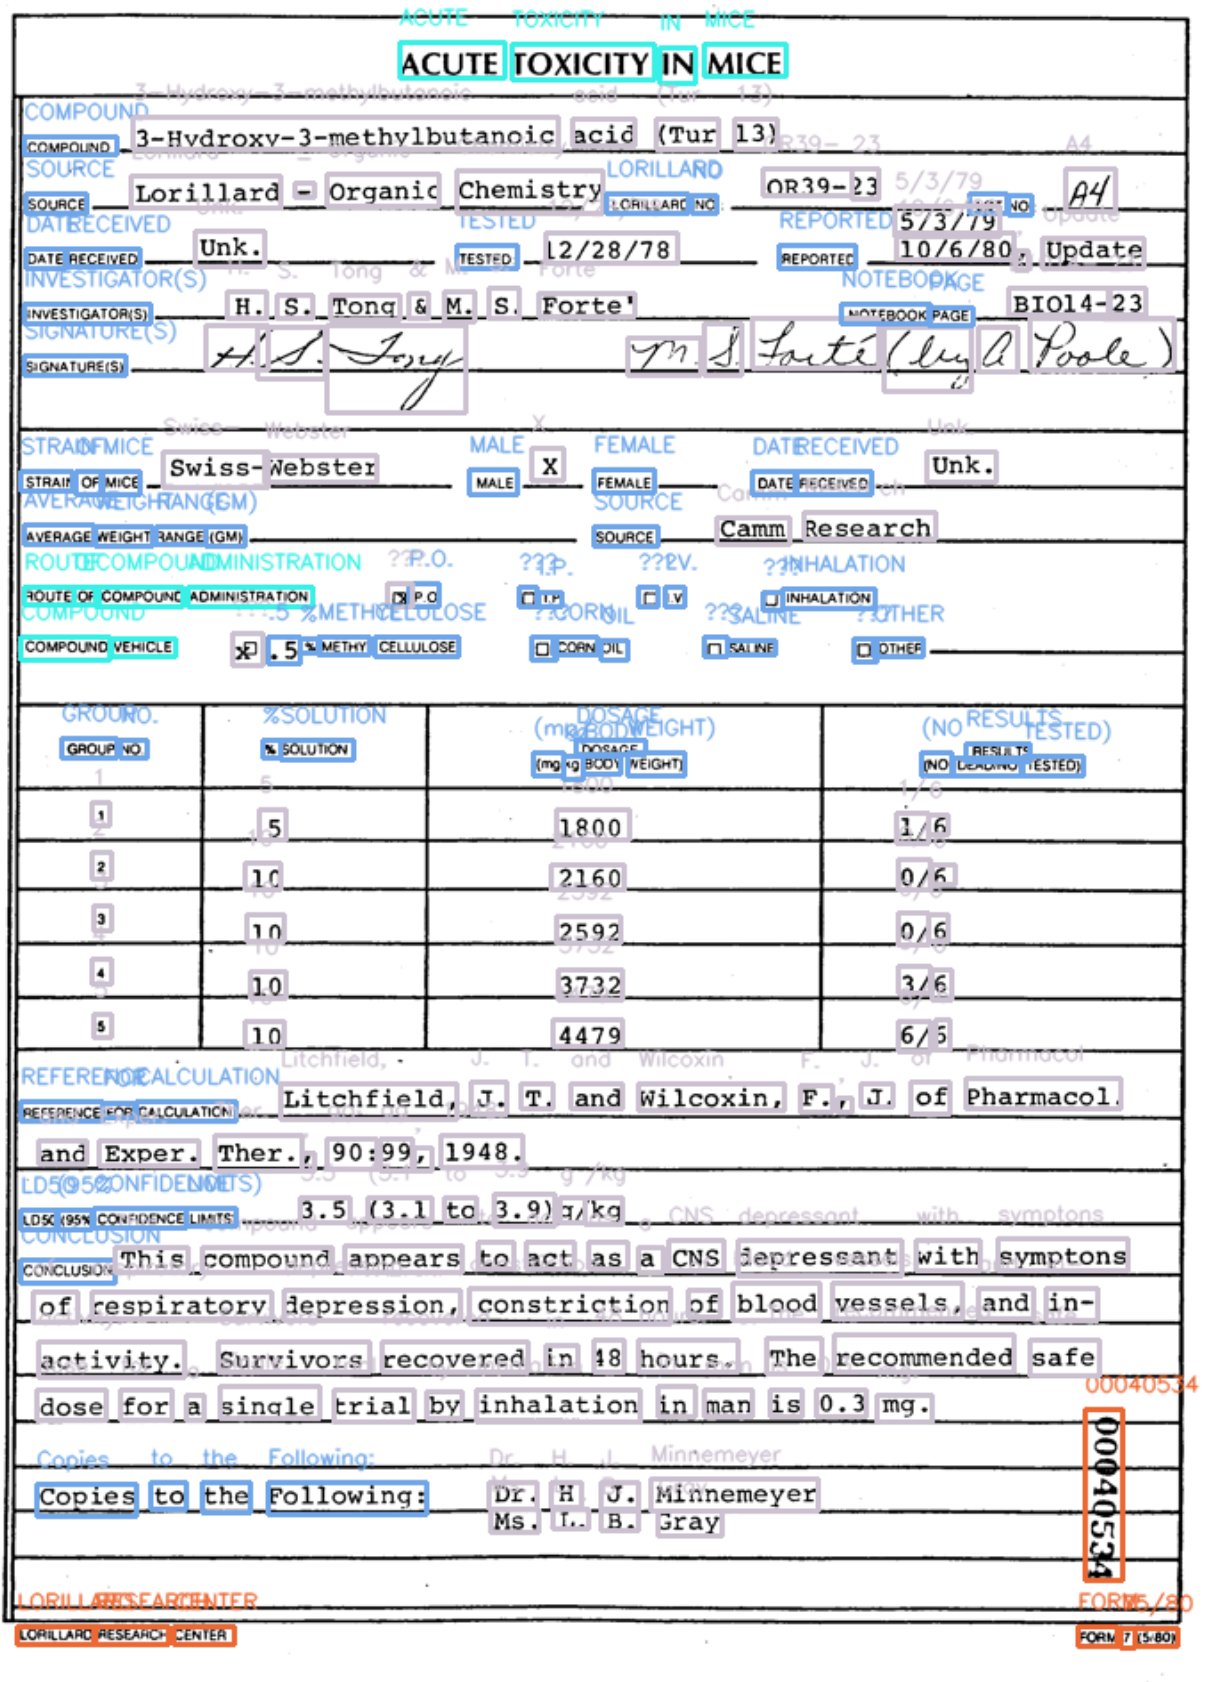

Ensure that each image has a corresponding annotation file and that there are no missing values.

Check data completeness for training and testing sets.

In [278]:
train_annotation_dir, train_image_dir = get_data_paths(DATA_DIR, 'raw', 'training_data')
test_annotation_dir, test_image_dir = get_data_paths(DATA_DIR, 'raw', 'testing_data')

train_file_names, paired_train_file_names, train_image_only_file_names, train_annotation_only_file_names = check_data_on_completeness(
    image_dir=train_image_dir,
    annotation_dir=train_annotation_dir
)

train_file_names, paired_test_file_names, test_image_only_file_names, test_annotation_only_file_names = check_data_on_completeness(
    image_dir=test_image_dir,
    annotation_dir=test_annotation_dir
)

In [279]:
total_train_files = len(set(paired_train_file_names + train_image_only_file_names + train_annotation_only_file_names))
total_test_files = len(set(paired_test_file_names + test_image_only_file_names + test_annotation_only_file_names))

logger.info(f"Training data completeness: {len(paired_train_file_names)}/{total_train_files} paired files.")
logger.info(f"Training data - Images only: {len(train_image_only_file_names)} files.")
logger.info(f"Training data - Annotations only: {len(train_annotation_only_file_names)} files.")

logger.info(f"Testing data completeness: {len(paired_test_file_names)}/{total_test_files} paired files.")
logger.info(f"Testing data - Images only: {len(test_image_only_file_names)} files.")
logger.info(f"Testing data - Annotations only: {len(test_annotation_only_file_names)} files.")

INFO:__main__:Training data completeness: 149/149 paired files.
INFO:__main__:Training data - Images only: 0 files.
INFO:__main__:Training data - Annotations only: 0 files.
INFO:__main__:Testing data completeness: 50/50 paired files.
INFO:__main__:Testing data - Images only: 0 files.
INFO:__main__:Testing data - Annotations only: 0 files.


Check all existing data types in the dataset

In [280]:
train_types = check_data_types(
    image_dir=train_image_dir,
    annotation_dir=train_annotation_dir
)
test_types = check_data_types(
    image_dir=test_image_dir,
    annotation_dir=test_annotation_dir
)

logger.info(f"General data types in dataset: {train_types.union(test_types)}")

INFO:__main__:General data types in dataset: {'.json', '.png'}


Define all languages present in the dataset

In [281]:
detected_languages = language_detection(train_annotation_dir, min_text_len=200)

for language, text in detected_languages.items():
    logger.info(f"Language: {language}\nText: {text}\n")

INFO:__main__:Language: en
Text: The Cigarette Test Station (CTS400) combines many of the stand- alone instruments that R&D currently uses to measure cigarette weight, pressure drop, ventilation, and hardness into one compact module. The CTS400 has the additional measurement of cigarette hardness in comparison with the CTS300. With this added, measurement R&D will be able to replace the Firmness Integrator that measures cigarette firmness in addition to other measurements that are mentioned above. The Firmness Integrator is no longer manufactured and parts are becoming difficult to obtain. Lastly, purchase of this instrument would provide similar capability as the Macon Plant and help facilitate comparisions between laboratories.



Print all types of textual phrases

In [282]:
logger.info(f"Unique classes of textual data labels: {set(output_all_classes_of_textual_data(train_annotation_dir) + output_all_classes_of_textual_data(test_annotation_dir))}")

INFO:__main__:Unique classes of textual data labels: {'answer', 'question', 'other', 'header'}


Calculate main statistics for textual annotations separately for train and test sets

In [283]:
train_statistics = main_statistics_for_textual_data(train_annotation_dir)
test_statistics = main_statistics_for_textual_data(test_annotation_dir)

logger.info(f"Training textual statistics:")
logger.info(f"Training mean length of text in bounding box: {train_statistics['mean']}")
logger.info(f"Training median length of text in bounding box: {train_statistics['median']}")
logger.info(f"Training min length of text in bounding box: {train_statistics['min']}")
logger.info(f"Training max length of text in bounding box: {train_statistics['max']}\n")

logger.info(f"Testing textual statistics:")
logger.info(f"Testing mean length of text in bounding box: {test_statistics['mean']}")
logger.info(f"Testing median length of text in bounding box: {test_statistics['median']}")
logger.info(f"Testing min length of text in bounding box: {test_statistics['min']}")
logger.info(f"Testing max length of text in bounding box: {test_statistics['max']}")

INFO:__main__:Training textual statistics:
INFO:__main__:Training mean length of text in bounding box: 16.993118337606262
INFO:__main__:Training median length of text in bounding box: 10.0
INFO:__main__:Training min length of text in bounding box: 0
INFO:__main__:Training max length of text in bounding box: 706

INFO:__main__:Testing textual statistics:
INFO:__main__:Testing mean length of text in bounding box: 21.67409948542024
INFO:__main__:Testing median length of text in bounding box: 11.0
INFO:__main__:Testing min length of text in bounding box: 0
INFO:__main__:Testing max length of text in bounding box: 711


In [284]:
number_of_channels(train_image_dir)

{1: 149}

In [285]:
number_of_channels(test_image_dir)

{1: 50}

In [286]:
calculate_main_statistic_for_images(train_image_dir)

{'mean': np.float64(0.768013422818792),
 'median': np.float64(0.762),
 'min': np.float64(0.754),
 'max': np.float64(0.863)}

In [287]:
calculate_main_statistic_for_images(test_image_dir)

{'mean': np.float64(0.7641999999999999),
 'median': np.float64(0.754),
 'min': np.float64(0.754),
 'max': np.float64(0.802)}

In [289]:
connected_component_analysis(
    image_path="/Users/nikolaynechay/Deloitte/Scanned-Documents-Processing/data/external/number-1-icon-circle-illustration-isolated-on-white-background-number-one-icon-vector.jpg",
    output_path="/Users/nikolaynechay/Deloitte/Scanned-Documents-Processing/data/intermediate/test_1.png"
)

Number of clasters: 2
